# Exploring NLP Pipeline - Part 2
As we mentioned in the lecture slides, an NLP pipeline is constructed from  the following steps: 
- Data acquisition, 
- Text extraction and cleaning 
- Pre-processing
- Feature Engineering
- Modelling
- Evaluation
- Deployement
- Monitoring & Model updating

In this notebook, we will try to explain how to convert pre-processed text into a numerical representation using the Bag Of Word (BOW) technique. Then fine different classification models will be created and evaluated to classify tweets into positive or negative sentiments. Next, you will learn how to evaluate different models and select the best model for future use. 

You can open the cloud version of this notebook using the following link:
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/Ali-Alameer/NLP/blob/main/week3_pipeline_part2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table> 

## Loading pre-processed data

Last week you stored the pre-processed tweets and labels in the CSV file. We need to load the file to continue our process of exploring different stages of the NLP pipeline.

Following code will read the CSV file using Pandas library and will load data into a datafram. A <b>Pandas DataFrame</b> is a 2 dimensional data structure, like a 2 dimensional array, or a table with rows and columns.

In [2]:
# Read data generated in the previous workshop
import requests

url = 'https://raw.githubusercontent.com/Ali-Alameer/NLP/main/data/processed_train_tweets.csv'
response = requests.get(url)

if response.status_code == 200:
    with open('processed_train_tweets.csv', 'wb') as file:
        file.write(response.content)
    print('CSV file downloaded successfully!')
else:
    print(f'Failed to download CSV file. Status code: {response.status_code}')

/Users/sooreoluwa/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


CSV file downloaded successfully!


In [3]:
import pandas as pd

# loading CSV files
train_df = pd.read_csv('processed_train_tweets.csv', index_col = 0)

Let to check the loaded data by displaying the first 5 tweets in the dataset.

In [4]:
# print the first 5 rows of training data
train_df.head()

,sentiment,clean_tweet,no_sentences,word_list,word_list_without_sw,final_tweet
tweet,,,,,,
@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,0,user when a father is dysfunctional and is so ...,2,"['user', 'when', 'a', 'father', 'is', 'dysfunc...","['user', 'father', 'dysfunctional', 'selfish',...",user father dysfunctional selfish drag kid dys...
@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,0,user user thanks for lyft credit i cannot use ...,2,"['user', 'user', 'thanks', 'for', 'lyft', 'cre...","['user', 'user', 'thanks', 'lyft', 'credit', '...",user user thanks lyft credit use offer wheelch...
bihday your majesty,0,bihday your majesty,1,"['bihday', 'your', 'majesty']","['bihday', 'majesty']",bihday majesty
#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,0,model i love you take with you all the time in...,2,"['model', 'i', 'love', 'you', 'take', 'with', ...","['model', 'love', 'take', 'time', 'areð\x9f\x9...",model love take time areð± ðððð ð...
factsguide: society now #motivation,0,factsguide society now motivation,1,"['factsguide', 'society', 'now', 'motivation']","['factsguide', 'society', 'motivation']",factsguide society motivation


To find out how the data is structured, let's take a look at it. There will be a result showing how many rows and columns the dataset contains by printing the shape attribute.

In [5]:
print(train_df.shape)

(31962, 6)


We can count the number of positive and negative tweets using the value_counts() method of a dataframe object.

In [6]:
train_df.sentiment.value_counts()

sentiment
0    29720
1     2242
Name: count, dtype: int64

The dataset description indicates that:
- <b>0</b> ==> <b>positive sentiments</b>
- <b>1</b> ==> <b>negative sentiments</b>

According to the result of the previous cell, there are 29,720 positive tweets and 2,242 negative tweets in the training dataset. As a result, the training dataset is <b>imbalanced</b> since the data points are not equal for the two classes.

For storing sentiments, a Python dictionary is an appropriate data structure.

In [7]:
# define a dictionary to map numbers to corresponding sentiments
map = {0: 'Positive', 1: 'Negative'}

## Feature engineering

Remember the input data is just a bunch of words for now. Machine learning models only understand and work on numbers. So we have to convert all the text into numbers. In NLP, this conversion of raw text to a suitable numerical form is called <b>text representation</b>. You will learn about this process in the following  lectures. 

Now that input is clean and ready, we convert it into numbers using something called the <b>"Bag of Words"</b> approach. We create a matrix table, where each row represents a sentence and each word will have a separate column for itself that represents its frequency. Let’s take an example, to make it easier. Let’s say there are 3 tweets like: 
- The food is really bad 
- The food is really good  
- The food is really good and tasty. 

This could be represented as a matrix using the bag of words approach as shown:

| Tweet Number | The | food | is | bad | really | good | tasty | and |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | 
| 1 |  1 |  1 |  1 |  1 |  1 |  0 |  0 |  0 | 
| 2 |  1 |  1 |  1 |  0 |  1 |  1 |  0 |  0 | 
| 3 |  1 |  1 |  1 |  0 |  1 |  1 |  1 |  1 | 

One problem about this method that you might not notice is that the order of the sentence is lost. There are other approaches to counter this, but we are just going to stick with this method at the moment. You will learn more about other approaches in the following workshops. 

The CountVectorizer class in the "sklearn.feature_extraction.text" module will be utilised to generate Bag of words for our tweets dataset.The Count Vectorizer function converts a list of words into a bag of words, however, notice that we specify something called the max features to it. As you might have seen in the bag of words illustration table, each word will have a separate column. This number of columns can explode into large numbers in big datasets. 

In [8]:
!pip3 install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.


In [9]:
from sklearn.feature_extraction.text import CountVectorizer

# create a count vertorizer object and set the size of the vocabulary to 8000
cv = CountVectorizer(max_features = 8000, ngram_range = (1,2))

# convert the dtype of final tweet column to unicode string and convert them to bag of words
X = cv.fit_transform(train_df['final_tweet'].values.astype('U')).toarray()
y = train_df['sentiment']

To avoid this we set the max columns as 8000, and keep the maximum occurring 8000 words. Finally, the `cv.fit_transform` function takes the cleaned data and converts it into the bag of words that we wanted.

In [10]:
print("X: ", X[0:5])
print("y: ",y[0:5])

X:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
y:  tweet
 @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run                        0
@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked    0
  bihday your majesty                                                                                                         0
#model   i love u take with u all the time in urð±!!! ððððð¦ð¦ð¦                                          0
 factsguide: society now    #motivation                                                                                       0
Name: sentiment, dtype: int64


## Modelling

One of the first decisions to make when starting a modeling phase is how to utilize the existing data. One common technique is to split the data into two groups typically referred to as the `training` and `testing` sets. The training set is used to train a model and the test set is used to evaluate the model. 

The `train_test_split` class of `sklearn.model_selection` class has been used to generate the training and test set in the following cell.

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print("number of tweets in training dataset: ", len(X_train))
print("number of tweets in testing dataset: ", len(X_test))

number of tweets in training dataset:  25569
number of tweets in testing dataset:  6393


In this section, we’ll build classifiers using five well-known machine learning algorithms: 
- Multinomial Naive Bayes,
- Bernoulli Naive Bayes, 
- logistic regression, 
- Random Forest, and 
- Decision Tree 

You don't need to worry about these models as you will learn detailed implementation of them in the `Machine Learning` module next semester. 

In the following section, we will import the required libraries to create our classifiers. To evaluate the models after they have been trained, a list of evaluation metrics is also imported.

In [12]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

Now we need to create an object from each of the classifiers model. 


In [13]:
mnb_model = MultinomialNB()
bnb_model = BernoulliNB()
lr_model = LogisticRegression(max_iter = 300, multi_class = "multinomial")
rfc_model = RandomForestClassifier(n_estimators = 50, random_state = 2, max_depth = 25)
tree_model = DecisionTreeClassifier(max_depth = 30)

Let's to creat a function to train a model and get the confusion metrix of the training data.

In [14]:
def train_classifier_get_confusion_metric(model, X_train, y_train, X_test, y_test):
    # train the model on training data
    model.fit(X_train, y_train)
    
    # evaluate the model
    y_pred = model.predict(X_test)

    # calculate the performance metrics
    confusion = confusion_matrix(y_test, y_pred)

    return confusion

In the following cell we will train only the logistic regression model and print the confution metrix of the model.

/Users/sooreoluwa/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Confusion Matrix:  [[5880   57]
 [ 214  242]]


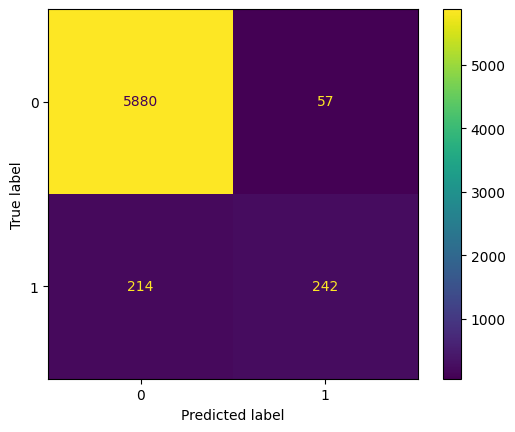

In [15]:
lr_confusion = train_classifier_get_confusion_metric(lr_model, X_train, y_train, X_test, y_test)

print("Confusion Matrix: ", lr_confusion)
disp = ConfusionMatrixDisplay(lr_confusion, display_labels = map.keys())
disp.plot()
plt.show()

### <font color='blue'>Exercise</font>

1- Calculate the accuracy of the liner regression model.

<div>
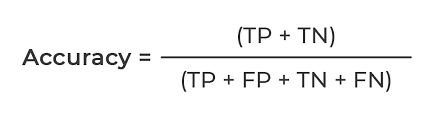
</div>

In [16]:
# calculate the accuracy of the model
TP = lr_confusion[0][0]
TN = lr_confusion[0][1]
FP = lr_confusion[1][0]
FN = lr_confusion[1][1]

lr_accuracy = (TP + TN) / (TP + FP + TN + FN)
lr_accuracy
# print(lr_accuracy)

0.9286719849835758

### <font color='blue'>Exercise</font>

1- Calculate the percision of the liner regression model.

<div>
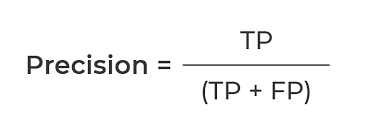
</div>

In [17]:
# calculate the precision of the model
lr_precision = TP / (TP + FP)
print(lr_precision)

0.9648834919593042


To optimize the code the following code defined a function that trains and returns the accuracy, and precision scores of the trained model. We also created a dictionary to store our model names. Then using a for loop we will call the function to train and store the socres for all of them.

In [18]:
def train_classifier(model, X_train, y_train, X_test, y_test):
    # train the model on training data
    model.fit(X_train, y_train)
    
    # evaluate the model
    y_pred = model.predict(X_test)

    # calculate the performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return accuracy, precision, confusion, recall, f1

# create a dictionary of models
models = {
    'Multinomial Naive Bayes': mnb_model,
    'Bernoulli Naive Bayes': bnb_model,
    'Logistic Regression': lr_model,
    'Random Forest Classifier': rfc_model,
    'Decision Tree Classifier': tree_model
}

# create a list to store performance of models
accuracy_scores = []
precision_scores = []
confusions = []
recall_scores = []
f1_scores = []

for model_name, model in models.items():
    
    # train the model on training data
    cur_accuracy, cur_precision, cur_confusion, cur_recall, cur_f1 = train_classifier(model, X_train, y_train, X_test, y_test)

    # print model performance
    print("Model: " , model_name)
    print("Accuracy: ", cur_accuracy)
    print("Precision: ", cur_precision)
    print("Recall: ", cur_recall)
    print("F1: ", cur_f1)
    print("Confusion Matrix: ", cur_confusion)
    disp = ConfusionMatrixDisplay(cur_confusion, display_labels = map.keys())
    disp.plot()
    plt.show()
    
    print('-' * 50)

    # append the performance metrics to a list
    accuracy_scores.append(cur_accuracy)
    precision_scores.append(cur_precision)
    confusions.append(cur_confusion)
    recall_scores.append(cur_recall)
    f1_scores.append(cur_f1)


KeyboardInterrupt: 

## Evaluation 

In order to show the performance of all models together a dataframe is created and displayed in the following cell.

In [ ]:
performance_df = pd.DataFrame({'Algorithm': models.keys(), 
                                'Accuracy': accuracy_scores, 
                                'Precision': precision_scores, 
                                'Recall': recall_scores, 
                                'F1': f1_scores,
                                'Confusion': confusions}).sort_values("Accuracy", ascending = False, ignore_index = True)

performance_df


NameError: name 'pd' is not defined

Among all other models, we can see that Logistic regression performs the best with an accuracy score of 95% followed by Multinomail Naive Bayes. As it is a classification task so we will not take recall and precision into consideration because here false-positive and false-negative don’t concern us.

Finally, we can save the model using a pickle file so that we can deploy it into the deployment phase.

In [ ]:
import pickle

file_name = "LogisticRegression.pickle"
pickle.dump(lr_model, open(file_name, "wb"))
